In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

base: str = "./datasets/"

# Load Transactions dataset

In [80]:
transactions = pd.read_csv(
    base + "transactions.csv",
    names=['timestamp', 'blockId', 'txId', 'isCoinbase', 'fee'],
    dtype={'blockId': np.int32, 'txId': np.int32, 'isCoinbase': np.int8},
    parse_dates=True
)

print(transactions.info())
#print(pd.concat([transactions.head(), transactions.tail()]))
print(transactions.head())
print(transactions.tail())

'''
max vals
timestamp: 1356997957 -> int64
blockId: 214562 -> int32
txId: 10572826 -> int32
isCoinbase -> np.bool_
fee: 17179869184 -> int64
'''

#print(transactions.nlargest(5, 'fee'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10572829 entries, 0 to 10572828
Data columns (total 5 columns):
 #   Column      Dtype
---  ------      -----
 0   timestamp   int64
 1   blockId     int32
 2   txId        int32
 3   isCoinbase  int8 
 4   fee         int64
dtypes: int32(2), int64(2), int8(1)
memory usage: 252.1 MB
None
    timestamp  blockId  txId  isCoinbase  fee
0  1231006505        0     0           1    0
1  1231469665        1     1           1    0
2  1231469744        2     2           1    0
3  1231470173        3     3           1    0
4  1231470988        4     4           1    0
           timestamp  blockId      txId  isCoinbase     fee
10572824  1356997957   214562  10572822           0  100000
10572825  1356997957   214562  10572823           0  100000
10572826  1356997957   214562  10572824           0  100000
10572827  1356997957   214562  10572825           0  100000
10572828  1356997957   214562  10572826           0  100000


'\nmax vals\ntimestamp: 1356997957 -> int64\nblockId: 214562 -> int32\ntxId: 10572826 -> int32\nisCoinbase -> np.bool_\nfee: 17179869184 -> int64\n'

# Load Inputs dataset

In [24]:
inputs = pd.read_csv(
    base + "inputs.csv",
    names=['txId', 'prevTxId', 'prevTxPos'],
    dtype={'txId': np.int32, 'prevTxId': np.int32, 'prevTxPos': np.int16},
)

# Load Outputs dataset 

In [25]:
outputs = pd.read_csv(
    base + "outputs.csv",
    names=['txId', 'txPos', 'addressId', 'amount', 'scriptType'],
    dtype={'txId': np.int32, 'txPos': np.int16, 'addressId': np.int32, 'amount': np.int64, 'scriptType': np.int8}
)

print(outputs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24613799 entries, 0 to 24613798
Data columns (total 5 columns):
 #   Column      Dtype
---  ------      -----
 0   txId        int32
 1   txPos       int16
 2   addressId   int32
 3   amount      int64
 4   scriptType  int8 
dtypes: int16(1), int32(2), int64(1), int8(1)
memory usage: 446.0 MB
None


# Load Mappings dataset

In [26]:
mappings = pd.read_csv(
    base + "mappings.csv",
    names=['addressId', 'hash'],
    dtype={'addressId': str, 'hash': np.int32}
)

# Script table

In [27]:
data = {'scriptCode': [0,1,2,3,4,5,6,7], 
        'scriptType':["Unknown", "P2PK", "P2KH", "P2SH", "RETURN", "EMPTY", "P2WPKH", "P2WSH"],
        'scriptSize': [0, 153, 180, 291, 0, 0, 0, 0]
       }

scripts = pd.DataFrame(
    data,
    #dtypes={'scriptCode': np.int8, 'scriptType': str, 'scriptSize': np.int8}
                  
)
print(scripts.info())
print(scripts)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   scriptCode  8 non-null      int64 
 1   scriptType  8 non-null      object
 2   scriptSize  8 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 320.0+ bytes
None
   scriptCode scriptType  scriptSize
0           0    Unknown           0
1           1       P2PK         153
2           2       P2KH         180
3           3       P2SH         291
4           4     RETURN           0
5           5      EMPTY           0
6           6     P2WPKH           0
7           7      P2WSH           0


# Size of transactions

         timestamp  txCount
0       1231006505        1
1       1231469665        1
2       1231469744        1
3       1231470173        1
4       1231470988        1
...            ...      ...
214464  1356996072      418
214465  1356996754      259
214466  1356997591      142
214467  1356997908        1
214468  1356997957      260

[214469 rows x 2 columns]


<Axes: title={'center': 'Numero di transazioni nel tempo'}, xlabel='timestamp'>

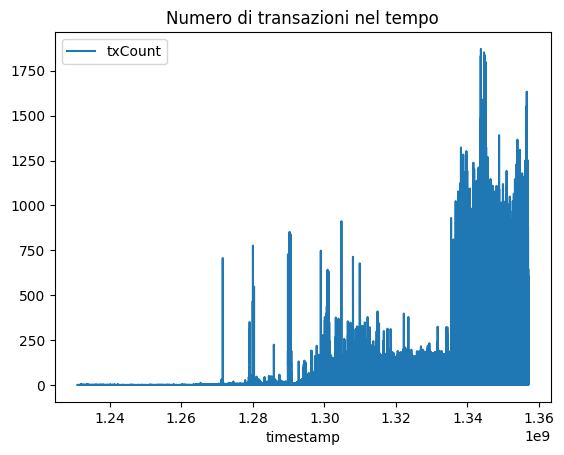

In [28]:
#Df to have the num of transactions for every timestamp
transCount = transactions \
    .groupby('timestamp')['txId'].count() \
    .reset_index() \
    .rename(columns={'txId':'txCount'})
print(transCount)

transCount.plot.line(title='Numero di transazioni nel tempo', x='timestamp', y='txCount')

In [157]:
def getTransactionInputs(inputsDf: pd.DataFrame, txId: int) -> pd.DataFrame:
    cond = inputsDf['txId'] == txId
    return inputsDf[cond]

def getTransactionOutputs(outputsDf: pd.DataFrame, txId: int) -> pd.DataFrame:
    cond = outputsDf['txId'] == txId
    return outputsDf[cond]

def getTransactionSize(transactionsDf: pd.DataFrame, inputsDf: pd.DataFrame, outputsDf: pd.DataFrame, txId: int) -> float:
    ''' Ottieni la dimensione di una transazione '''
    
    INPUT_SIZE = 40
    OUTPUT_SIZE = 9

    num_inputs = len(getTransactionInputs(inputsDf, txId))
    num_outputs = len(getTransactionOutputs(outputsDf, txId))
    script_size = 0

    # TODO: num_outputs > 1 ==> script diversi; quale contare?
    return INPUT_SIZE * num_inputs + OUTPUT_SIZE * num_outputs + script_size


def getTransactionsAtTimestamp(transactionsDf: pd.DataFrame, timestamp: int) -> pd.DataFrame:
    cond = transactionsDf['timestamp'] == timestamp
    return transactionsDf[cond]


def getCongestionAtTs(timestamp: int, transactionsDf: pd.DataFrame, inputsDf: pd.DataFrame, outputsDf: pd.DataFrame):
    transactions_at_ts = getTransactionsAtTimestamp(transactionsDf, timestamp)

    tx_sizes = [getTransactionSize(transactionsDf, inputsDf, outputsDf, txId) for txId in transactions_at_ts['txId']]

    return sum(tx_sizes)


def getAverageFeeAtTimestamp(transactionsDf: pd.DataFrame, timestamp: int):
    tx_ts: pd.DataFrame = getTransactionsAtTimestamp(transactionsDf, timestamp)

    return tx_ts['fee'].mean()


def getTsCongestionDf(transactionsDf: pd.DataFrame, inputsDf: pd.DataFrame, outputsDf: pd.DataFrame) -> pd.DataFrame:    
    not_coinbase = transactionsDf['isCoinbase'] == 0
    transactionsDf = transactionsDf[not_coinbase]
    
    timestamps = transactionsDf['timestamp'][0:30000]
    congs = timestamps.apply(getCongestionAtTs, args=(transactionsDf, inputsDf, outputsDf))
    fees = timestamps.apply(lambda ts: getAverageFeeAtTimestamp(transactionsDf, ts))
    
    return pd.DataFrame({'Timestamp': timestamps, 'Congestion': congs, 'Fee': fee})

In [78]:
TX_ID = 10888

txInputs = getTransactionInputs(inputs, TX_ID)
print(len(txInputs))
print(txInputs)

txOutputs = getTransactionOutputs(outputs, TX_ID)
print(len(txOutputs))
print(txOutputs)

1
      txId  prevTxId  prevTxPos
640  10888     10760          0
2
        txId  txPos  addressId      amount  scriptType
10915  10888      0      10849  1000000000           2
10916  10888      1      10722  4000000000           1


In [31]:
#get all transactions with more then 1 output
'''
for id in transactions['txId']:
    n_outputs = len(getTransactionOutputs(outputs, id))

    if n_outputs != 1:
        print(f'txId:{id:}, num_outputs: {n_outputs}')

print("end")'''

'\nfor id in transactions[\'txId\']:\n    n_outputs = len(getTransactionOutputs(outputs, id))\n\n    if n_outputs != 1:\n        print(f\'txId:{id:}, num_outputs: {n_outputs}\')\n\nprint("end")'

In [133]:
# test getTransactionsAtTimestamp; getCongestionAtTs
timestamp = 1356997591
transactions_ncb = transactions[transactions['isCoinbase'] == 0]

tx_ts = getTransactionsAtTimestamp(transactions_ncb, timestamp)

print(tx_ts)

congestion = getCongestionAtTs(timestamp, transactions_ncb, inputs, outputs)
print(f'congestion @{timestamp}: {congestion}')

fee = getAverageFeeAtTimestamp(transactions_ncb, timestamp)
print(f'avg fee @{timestamp}: {fee}')

           timestamp  blockId      txId  isCoinbase    fee
10572428  1356997591   214561  10572426           0      0
10572429  1356997591   214561  10572427           0      0
10572430  1356997591   214561  10572428           0      0
10572431  1356997591   214561  10572429           0  20000
10572432  1356997591   214561  10572430           0      0
...              ...      ...       ...         ...    ...
10572564  1356997591   214561  10572562           0      0
10572565  1356997591   214561  10572563           0      0
10572566  1356997591   214561  10572564           0      0
10572567  1356997591   214561  10572565           0      0
10572568  1356997591   214561  10572566           0      0

[141 rows x 5 columns]
congestion @1356997591: 11358
avg fee @1356997591: 39178.82269503546


In [154]:
# fee test
from datetime import datetime

ts_start = 1231006505
ts_end = 1356997957

random_ts = transactions.sample(n=5)['timestamp'].to_list()
print(random_ts)
#ts = random.randint(ts_start, ts_end)

for ts in random_ts:
    fee = getAverageFeeAtTimestamp(transactions, ts)
    print(f'avg fee @{ts}: {fee}')


[1338813701, 1346324962, 1355265088, 1340386327, 1341773667]
avg fee @1338813701: 54471.60883280757
avg fee @1346324962: 228361.9297385621
avg fee @1355265088: 105815.60283687944
avg fee @1340386327: 28064.44230769231
avg fee @1341773667: 47887.95977011494


In [158]:
congDf: pd.DataFrame = getTsCongestionDf(transactions, inputs, outputs)

print(congDf.info())

'''print(congDf.head())
print(congDf.tail())'''

#congDf['Fee'].plot(kind='hist')


KeyboardInterrupt: 

In [ ]:
# plots
fig, axs = plt.subplots(1, 3, figsize=(20, 16))  # 1 rows, 3 column

congDf.plot(kind='line', x='Congestion', y='Fee', title='Andamento fee rispetto congestione', ax=axs[0])
congDf.plot(kind='line', x='Timestamp', y='Congestion', title='Andamento congestione nel tempo', ax=axs[1])
congDf.plot(kind='line', x='Timestamp', y='Fee', title='Andamento fee nel tempo', ax=axs[2])
